In [1]:
class ContrastCurve(object):
    def __init__(self, path, Star, K_klip, xs, ys, C, box = 50, sepformat = 'lambda/D',
                 sciencecube = [], refcube = [], templatecube = [],
                 sep_cutout_region = [0,0], pa_cutout_region = [0,0],
                 normalize = True, normalizebymask = False, normalizing_radius = [],
                 mask_core = True, mask_outer_annulus = True,
                 mask_radius = 5., outer_mask_radius = 50.,
                 subtract_radial_profile = True,
                 save_results_filename = None, wavelength = 3.9
                ):
        ''' Class for computing SNR are a variety of separations and contrasts and plotting results

        Inject a vareity of fake signals from an array of separations and contrasts, and 
        compute the signal-to-noise
        ratio at

        Written by Logan A. Pearce, 2020
        Dependencies: numpy, scipy, pandas

        Attributes:
        -----------
        path : str
            path to data set, directory must contain "CleanList"
        Star : 'A' or 'B'
            star to put the fake signal around
        K_klip : int
            number of KLIP modes to use in psf subtraction
        sep : flt
            separation of planet placement in either arcsec, mas, pixels, or lambda/D [prefered]
        C : flt
            desired contrast of planet with central object
        box : int
            size of box of size "2box x 2box" for image stamps, if cubes aren't supplied by user
        sepformat : str
            format of inputted desired separation. Either 'arcsec', 'mas', pixels', or 'lambda/D'.
            Default = 'lambda/D'
        sciencecub, refcube, templatecube : 3d arr
            user input the base images to use in injection for science images, psf templates, 
            and KLIP reference basis sets. 
        snrs : 2d arr
            signal to noise ratios at the computed separation (columns) and contrasts (rows) locations
        runtime : flt
            time to perform computation
        wavelength : flt
            central wavelength of filter band in microns.  Default = 3.9
        '''
        
        self.path = path
        self.Star = Star
        self.K_klip = K_klip
        self.xs = xs
        self.ys = ys
        self.C = C
        self.sciencecube = sciencecube
        self.refcube = refcube
        self.templatecube = templatecube
        self.sepformat = sepformat
        self.sep_cutout_region = sep_cutout_region
        self.pa_cutout_region = pa_cutout_region
        self.normalize = normalize
        self.normalizebymask = normalizebymask
        self.normalizing_radius = normalizing_radius
        self.inner_mask_radius = mask_radius
        self.outer_mask_radius = outer_mask_radius
        self.mask_core = mask_core
        self.mask_outer_annulus = mask_outer_annulus
        self.subtract_radial_profile = subtract_radial_profile
        self.save_results_filename = save_results_filename
        self.wavelength = wavelength
        if np.size(self.sciencecube) == 1:
            self.box = box
        else:
            self.box = self.sciencecube.shape[1]/2

def get_distance(source_ids, catalog = 'gaiadr3.gaia_source'):
    '''Use Gaia DR2 source id to return the distance and error in parsecs'''
    import warnings
    warnings.filterwarnings("ignore")
    import numpy as np
    from astroquery.gaia import Gaia
    from myastrotools.tools import distance
    try:
        d,e = np.array([]),np.array([])
        for source_id in source_ids:
            job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(source_id))
            j = job.get_results()
            di,ei = distance(np.array(j['parallax']),np.array(j['parallax_error']))
            d = np.append(d,di)
            e = np.append(e,ei)
            print('For',source_id,'d=',[di,ei])
    except:
        job = Gaia.launch_job("SELECT * FROM "+catalog+" WHERE source_id = "+str(source_ids))
        j = job.get_results()
        d,e = distance(np.array(j['parallax']),np.array(j['parallax_error']))
    return d,e

def lambdaoverD_to_arcsec(lamb, D = 6.5):
    """ Compute lamb/D.  Default is for Magellan mirror and CLIO narrow camera pixelscale.
        Inputs:
            lamb [um]: central wavelength of filter in microns.  Astropy unit object preferred
            D [m]: primary mirror diameter.  Astropy unit object required
            pixscale [mas/pix]: 
        Returns:
            loverd [arcsec]: lambda/D in arcsec per L/D
    """
    arcsec = (0.2063*(lamb/D))
    return arcsec

def lambdaoverD_pix(lamb, pixscale = 15.9, D = 6.5):
    import astropy.units as u
    loverd = lambdaoverD_to_arcsec(lamb, D = D)
    loverd_pix = loverd*u.arcsec.to(u.mas) / pixscale
    return loverd_pix

def lod_to_pixels(lod, lamb, pixscale = 15.9, D = 6.5):
    """ Convert separation in lambda/D to pixels
    """
    loverd_pix = lambdaoverD_pix(lamb, pixscale=pixscale, D = D)
    return lod*loverd_pix

import numpy as np
import matplotlib.pyplot as plt

def update_progress(n,max_value):
    ''' Create a progress bar
    
    Args:
        n (int): current count
        max_value (int): ultimate values
    
    '''
    import sys
    barLength = 20 # Modify this to change the length of the progress bar
    status = ""
    progress = np.round(float(n/max_value),decimals=2)
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    #if progress >= 1.:
    #    progress = 1
    #    status = "Done...\r\n"
    if n == max_value:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\r{0}% ({1} of {2}): |{3}|  {4}".format(np.round(progress*100,decimals=1), 
                                                  n, 
                                                  max_value, 
                                                  "#"*block + "-"*(barLength-block), 
                                                  status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [1]:
path = "BDI1350/box90/"
import pickle
sp = pickle.load(open('system-parameters.pkl','rb'))
print([i for i in sp.keys() if path in i])

['BDI1350/box90/box', 'BDI1350/box90/StarName', 'BDI1350/box90/distance', 'BDI1350/box90/sep', 'BDI1350/box90/C', 'BDI1350/box90/K_klipA', 'BDI1350/box90/K_klipB', 'BDI1350/box90/today', 'BDI1350/box90/filesuffix', 'BDI1350/box90/mass_limit_filesuffix', 'BDI1350/box90/binary_sep', 'BDI1350/box90/obs_dm', 'BDI1350/box90/Nimages', 'BDI1350/box90/contA', 'BDI1350/box90/contB', 'BDI1350/box90/ao_modes', 'BDI1350/box90/humidity', 'BDI1350/box90/seeing', 'BDI1350/box90/obs_date', 'BDI1350/box90/massA', 'BDI1350/box90/massB', 'BDI1350/box90/WISE1', 'BDI1350/box90/WISE2', 'BDI1350/box90/Gmag', 'BDI1350/box90/J', 'BDI1350/box90/H', 'BDI1350/box90/K', 'BDI1350/box90/sourceidA', 'BDI1350/box90/sourceidB', 'BDI1350/box90/MGmag', 'BDI1350/box90/MJ', 'BDI1350/box90/MH', 'BDI1350/box90/MK', 'BDI1350/box90/GaiaBP_A', 'BDI1350/box90/GaiaRP_A', 'BDI1350/box90/GaiaBP-RP_A', 'BDI1350/box90/GaiaBP_B', 'BDI1350/box90/GaiaRP_B', 'BDI1350/box90/GaiaBP-RP_B', 'BDI1350/box90/MWISE1', 'BDI1350/box90/MWISE2', 'BD

In [3]:
sourceid = sp[path+'sourceidA']

distanceA = get_distance(sourceid)
K_klip = sp[path+'K_klipA']
K_klip

30

In [2]:
import time

Star = 'A'

# Open saved cleaned cubes:
astamp = fits.getdata('acube_box90_bpf-best.fits')
bstamp = fits.getdata('bcube_box90_bpf-best.fits')

box = astamp.shape[1] * 0.5
inner_mask = 1.

inner_mask = lod_to_pixels(inner_mask, 3.77)
outer_mask = box



NameError: name 'lod_to_pixels' is not defined

119.21924669048461
29.5 -16.499999999999996


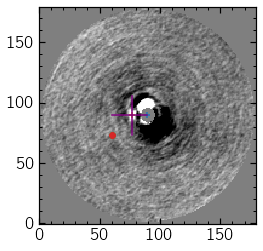

In [4]:
# Define grid of (x,y)
xc,yc = 0.5*((2*box)-1), 0.5*((2*box)-1)
xs,ys = 76.5, 89.5
xmin, xmax = 60, xc
ymin = 73
ymax = ys + (ys-ymin)
ymin,ymax

xrange = np.arange(xmin,xmax,0.25)
yrange = np.arange(ymin,ymax,0.25)

from astropy.io import fits
reduced_image = fits.getdata('A_klipcube_BDI1350_box90_Kklip5-10-15-20-30-40_im3_om90_2021-8-19.fit')

from astropy.visualization import (ImageNormalize, ZScaleInterval)

%matplotlib inline
im = reduced_image[5]
plt.imshow(im, norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.scatter(xc,yc,marker='+')
plt.scatter(xs,ys,marker='+')
plt.plot(xrange, [ys]*len(xrange), color='purple')
plt.plot([xs]*len(yrange), yrange, color='purple')

i = 0
plt.scatter(xrange[0],yrange[0])

x,y = (xc - xrange[0]), (yc - yrange[0])
sep = np.sqrt(x**2 + y**2)
pa = (np.degrees(np.arctan2(x,-y)) ) % 360
xx = sep*np.sin(np.radians(pa))
yy = sep*np.cos(np.radians(pa))
print(pa)
print(xx,yy)
plt.scatter(xc - xx, yc + yy)

In [6]:
# Define array of contrasts:
fluxrange = np.arange(4.5,7.2,0.1)
len(fluxrange)*len(xrange)*len(yrange),fluxrange[0]

(420552, 4.5)

In [7]:
import time

Star = 'A'

box = astamp.shape[1] * 0.5
inner_mask = 0.5

inner_mask = lod_to_pixels(inner_mask, 3.77)
outer_mask = box

k = pd.read_csv('CleanList.csv', comment='#')


# These images are in L' band -> wavelength = 3.77

# initialize the contrast curve object:
obj = ContrastCurve(path, Star, K_klip, sep, xrange, yrange,
                     normalize = True,
                     mask_core = True, mask_outer_annulus = True,
                     mask_radius = inner_mask, outer_mask_radius = outer_mask,
                     subtract_radial_profile = False,
                     sciencecube = astamp,
                     refcube = bstamp,
                     templatecube = astamp,
                     save_results_filename = 'HIPC_neg_signal_injection.pkl', 
                     wavelength = 3.77
                    )

## The following relies on tools for BDI from Pearce et al. 2022.  They can be found here: https://github.com/logan-pearce/cliotools

<IPython.core.display.Javascript object>


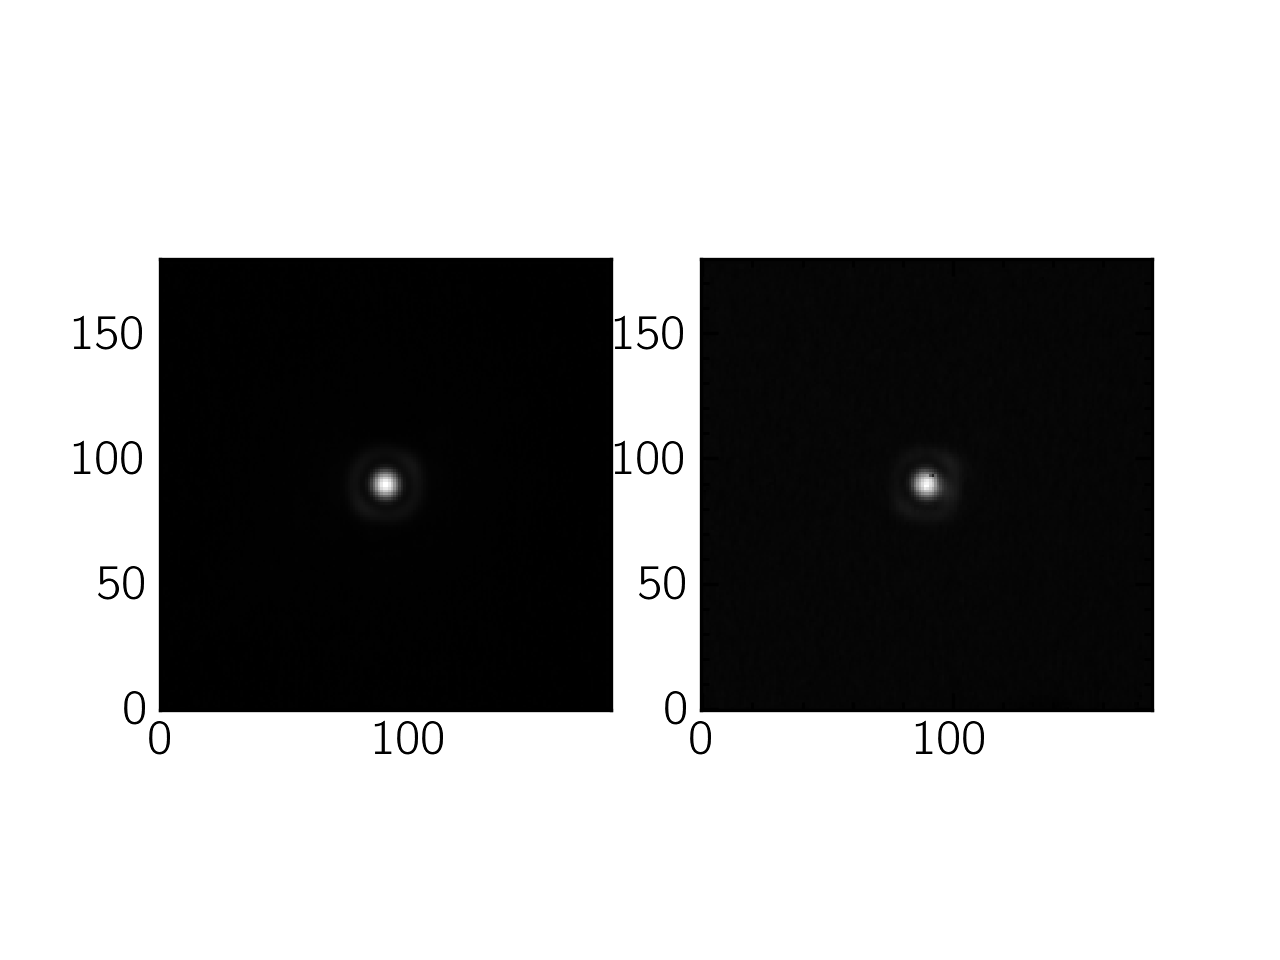

In [8]:
from cliotools.bditools import injectplanet,makeplanet
from cliotools.bditools import contrast

template = np.median(bstamp, axis=0)

sciencecube = astamp

i = 0
center = (0.5*((obj.sciencecube.shape[2])-1),0.5*((obj.sciencecube.shape[1])-1))
TC = contrast(obj.sciencecube[i],template,center,center)
%matplotlib notebook
plt.subplot(121)
plt.imshow(template)
plt.subplot(122)
plt.imshow(sciencecube[i])

223.2959


<IPython.core.display.Javascript object>


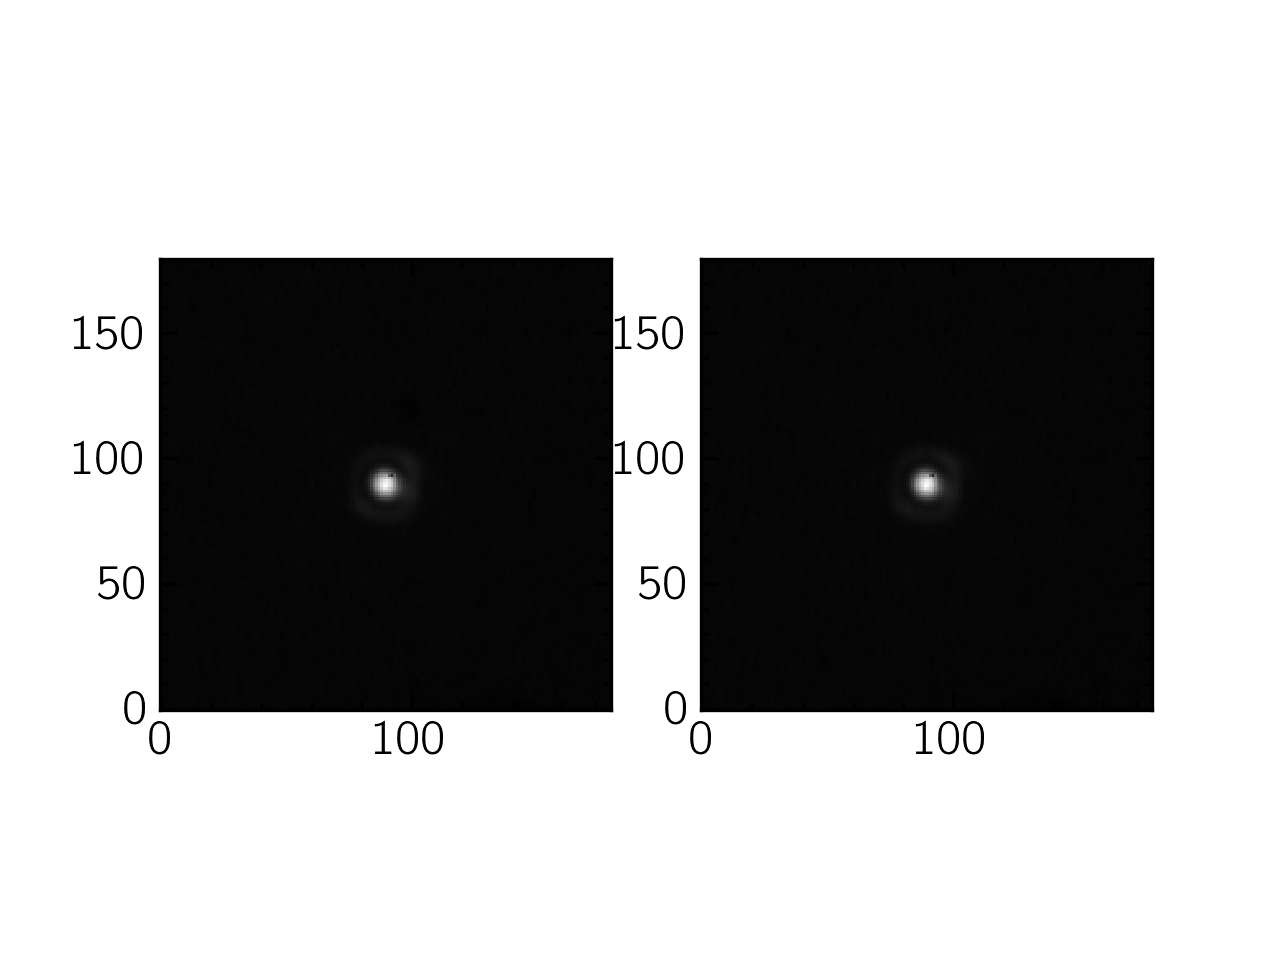

In [14]:

imhdr = fits.getheader(k['filename'].loc[i])
def injectplanet(image, imhdr, template, x, y, contrast, TC, xc, yc, 
                 pixscale = 15.9,
                 wavelength = 'none',
                 box = 70,
                 inject_negative_signal = False
                ):
    ''' Using a template psf, place a fake planet at the desired x,y and
        contrast from the central object.  PA is measured relative to true north
        (rather than up in image)
    '''
    from cliotools.bditools import makeplanet
    
    # compute sep in pixels

    newx, newy = (xc - x), (yc - y)
    sep = np.sqrt(newx**2 + newy**2)
    pa = (np.degrees(np.arctan2(newx,-newy)) ) % 360
    
    # pa input - rotate from angle relative to north to angle relative to image up:
    #    do the opposite of what you do to derotate images
    NORTH_CLIO = -1.80
    derot = (imhdr['ROTOFF'] - 180. + NORTH_CLIO) % 360
    print(derot)
    
    pa = (pa + derot)
        
    # Get cartesian location of planet:
    xx = sep*np.sin(np.radians((pa)))
    yy = sep*np.cos(np.radians((pa)))
    xs = np.int_(np.floor(xc-xx))
    ys = np.int_(np.floor(yc+yy))
    # Make planet from template at desired contrast
    Planet = makeplanet(template, contrast, TC)
    # Make copy of image:
    synth = image.copy()
    # Get shape of template:
    boxy, boxx = np.int_(Planet.shape[0]/2),np.int_(Planet.shape[1]/2)
    x,y = xs,ys
    ymin, ymax = y-boxy, y+boxy
    xmin, xmax = x-boxx, x+boxx
    # Correct for sources near image edge:
    delta = 0
    if ymin < 0:
        delta = ymin
        ymin = 0
        Planet = Planet[(0-delta):,:]
    if ymax > image.shape[0]:
        delta = ymax - image.shape[0]
        ymax = image.shape[0]
        Planet = Planet[:(2*boxy-delta) , :]
    if xmin < 0:
        delta = xmin
        xmin = 0
        Planet = Planet[:,(0-delta):]
    if xmax > image.shape[1]:
        delta = xmax - image.shape[1]
        xmax = image.shape[1]
        Planet = Planet[:,:(2*boxx-delta)]
    if inject_negative_signal:
        Planet = Planet * (-1)
    # account for integer pixel positions:
    if synth[ymin:ymax,xmin:xmax].shape != Planet.shape:
        try:
            synth[ymin:ymax+1,xmin:xmax] = synth[ymin:ymax+1,xmin:xmax] + (Planet)
        except:
            synth[ymin:ymax,xmin:xmax+1] = synth[ymin:ymax,xmin:xmax+1] + (Planet)
    else:
        synth[ymin:ymax,xmin:xmax] = synth[ymin:ymax,xmin:xmax] + (Planet)
    return synth

i = 0
synth = injectplanet(sciencecube[i], imhdr, template, xrange[i], yrange[i], fluxrange[i], TC, xc, yc, 
                 box = box,
                 inject_negative_signal = True
                )

%matplotlib inline
plt.subplot(121)
plt.imshow(synth)
plt.subplot(122)
plt.imshow(sciencecube[i])

In [15]:

def injectplanets(image, imhdr, template, x, y, contrast, TC, xc, yc, 
                  inject_negative_signal = True, **kwargs):
    ''' Wrapper for injectplanet() that allows for multiple fake planets in one image.
        Parameters are same as injectplanet() except sep, pa, and contrast must all be
        arrays of the same length.  **kwargs are passed to injectplanet().
    '''
    synth = image.copy()
    try:
        for i in range(len(sep)):
            synth1 = injectplanet(synth, imhdr, template, x[i], y[i], contrast[i], TC, xc, yc, 
                                      inject_negative_signal = inject_negative_signal,
                                      **kwargs)
            synth = synth1.copy()
    except:
        synth = injectplanet(synth, imhdr, template, x, y, contrast, TC, xc, yc, 
                                      inject_negative_signal = inject_negative_signal,
                                      **kwargs)
    return synth

class SyntheticSignal(object):
    def __init__(self, k, Star, x, y, C, boxsize = 50,
                sciencecube = [], refcube = [], 
                template = [], TC = None, use_same = True, verbose = True,
                inject_negative_signal = True, wavelength = 3.77
                ):
        ''' Class for creating and controling images with synthetic point source signals ("planet") injected.
        '''
        self.k = k
        self.Star = Star
        self.x = x
        self.y = y
        self.C = C
        self.verbose = verbose
        self.sciencecube = sciencecube
        self.refcube = refcube
        self.template = template
        box = sciencecube.shape[1] / 2
        
        synthcube = np.zeros(np.shape(self.sciencecube))
        # Inject planet signal into science target star:
        center = (0.5*((self.sciencecube.shape[2])-1),0.5*((self.sciencecube.shape[1])-1))
        # inject signal:
        for i in range(self.sciencecube.shape[0]):
            if TC == None:
                from cliotools.bditools import contrast
                # Get template constrast of refcube to sciencecube
                TC = contrast(self.sciencecube[i],self.templatecube[i],center,center)
            imhdr = fits.getheader(k['filename'].loc[i])
            synth = injectplanets(self.sciencecube[i], imhdr, self.template, x, y, C, TC, box, box,
                                  wavelength = wavelength, box = box, 
                                        inject_negative_signal = inject_negative_signal)
            synthcube[i,:,:] = synth
                
        self.synthcube = synthcube.copy()
        
        
SynthCube = SyntheticSignal(k, Star, xrange[i], yrange[i], fluxrange[i],
                            sciencecube = obj.sciencecube, refcube = obj.refcube,
                            template = template, TC = TC, boxsize = box, inject_negative_signal = True)

223.2959
223.4861
223.66539999999998
223.85229999999999
224.0402
224.2256
224.41029999999998
224.59449999999998
224.77769999999998
224.95059999999998
225.13479999999998
225.31619999999998
229.076
229.2432
229.40959999999998
229.5772
229.74429999999998
229.9089
230.0643
230.2295
230.3923
230.5547
230.7147
230.8776
232.38389999999998
232.539
232.69490000000002
232.849
233.00240000000002
233.1567
233.31060000000002
233.4606
233.6134
233.75760000000002
233.9076
234.0589
235.42290000000003
235.5686
235.71210000000002
235.8551
235.9977
236.1396
236.2827
236.4237


<IPython.core.display.Javascript object>


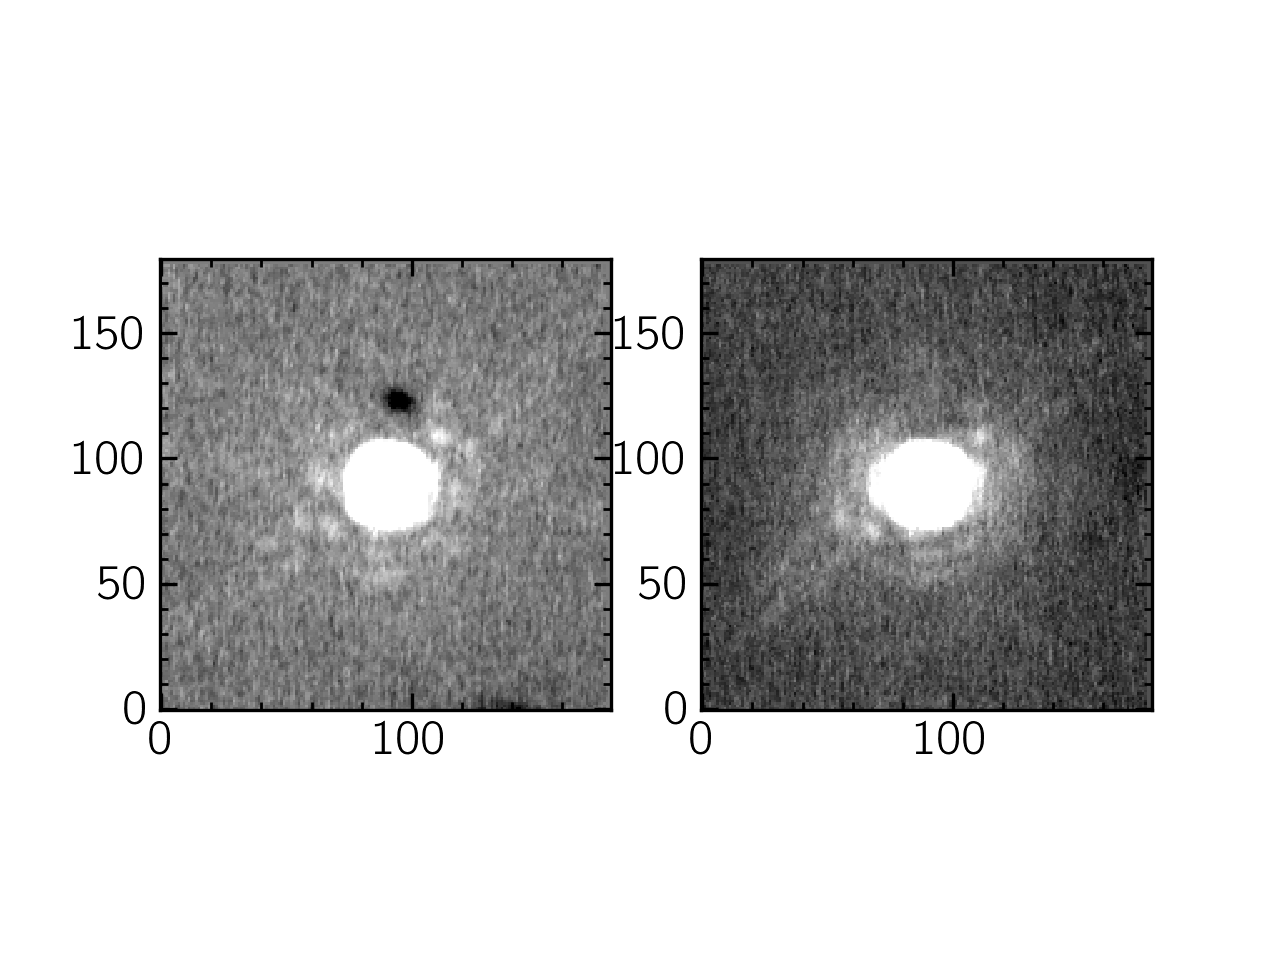

In [16]:
%matplotlib inline
plt.subplot(121)
im = np.median(SynthCube.synthcube, axis=0)
plt.imshow(im, norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.subplot(122)
im = np.median(SynthCube.refcube, axis=0)
plt.imshow(im, norm = ImageNormalize(im, interval=ZScaleInterval(),))

<IPython.core.display.Javascript object>


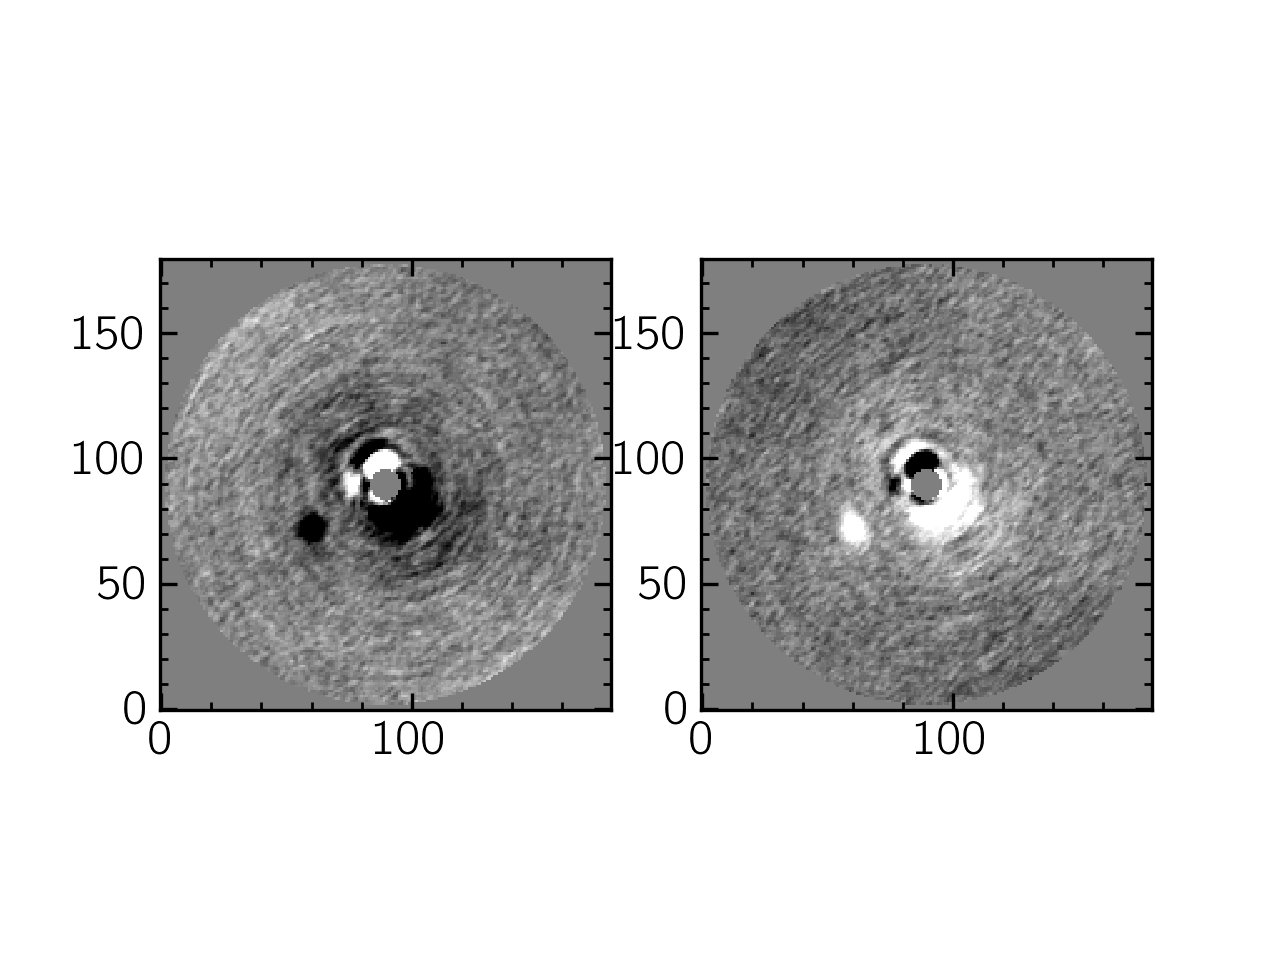

In [17]:


Star = 'A'

box = astamp.shape[1] * 0.5
inner_mask = 0.5
from cliotools.bditools import lod_to_pixels
inner_mask = lod_to_pixels(inner_mask, 3.77)
outer_mask = box
K_klip = 30

k = pd.read_csv('CleanList.csv', comment='#')
fullpath = '../../../bdi/'+path

from cliotools.bdi import BDI
SynthCubeObjectBDI2 = BDI(k, fullpath, K_klip = K_klip, 
                    boxsize = box, normalize = True, normalizebymask = False,       
                    inner_mask_core = True,        
                    inner_radius_format = 'pixels',
                    inner_mask_radius = inner_mask,        
                    outer_mask_annulus = True,     
                    outer_radius_format = 'pixels',
                    outer_mask_radius = outer_mask,       
                    mask_cval = 0,       
                    subtract_radial_profile = False,          
                    verbose = False,               
                    acube = SynthCube.synthcube,    
                    bcube = SynthCube.refcube   
                   )
# Do klip reduction:
SynthCubeObjectBDI2.Reduce(interp='bicubic',
             rot_cval=0.,
             mask_interp_overlapped_pixels = True
            ) 

%matplotlib notebook
plt.subplot(121)
im = SynthCubeObjectBDI2.A_Reduced
plt.imshow(im, norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.subplot(122)
im = SynthCubeObjectBDI2.B_Reduced
plt.imshow(im, norm = ImageNormalize(im, interval=ZScaleInterval(),))

In [26]:
grabbed

array([-2.52907231e-05, -3.86768668e-05, -1.57258846e-05, -1.40468469e-06,
        2.47780787e-06, -1.19475663e-05, -3.20720039e-05, -1.60964500e-05,
       -4.92427573e-06, -3.82520258e-05, -2.42069114e-05, -2.75633279e-06,
        6.50986182e-06,  1.56436851e-05,  3.00217517e-06, -1.67517168e-05,
       -9.01422613e-06, -5.62265223e-06, -2.25584485e-05, -3.57597603e-05,
       -3.39736189e-05, -2.62993094e-05, -3.37217041e-06,  2.37383282e-05,
        4.15428802e-05,  3.16613687e-05,  1.30665600e-05,  2.87143054e-06,
        2.47789820e-06, -7.81639965e-06, -2.85435835e-05, -2.33096386e-05,
       -2.62991872e-05, -3.09636354e-05, -2.27212734e-05, -1.51784671e-05,
        1.37305543e-05,  3.87752020e-05,  4.17093541e-05,  3.87735042e-05,
        2.95047155e-05,  1.35507195e-05, -1.53005047e-05, -3.25172263e-05,
       -3.05660192e-05,  1.77194636e-05, -1.91574986e-05, -1.89395852e-05,
       -9.72211591e-06, -7.19945886e-06,  1.83875446e-05,  6.01555049e-05,
        5.50732344e-05,  

4.332383239738482e-05
4.279908412003377e-05


<IPython.core.display.Javascript object>


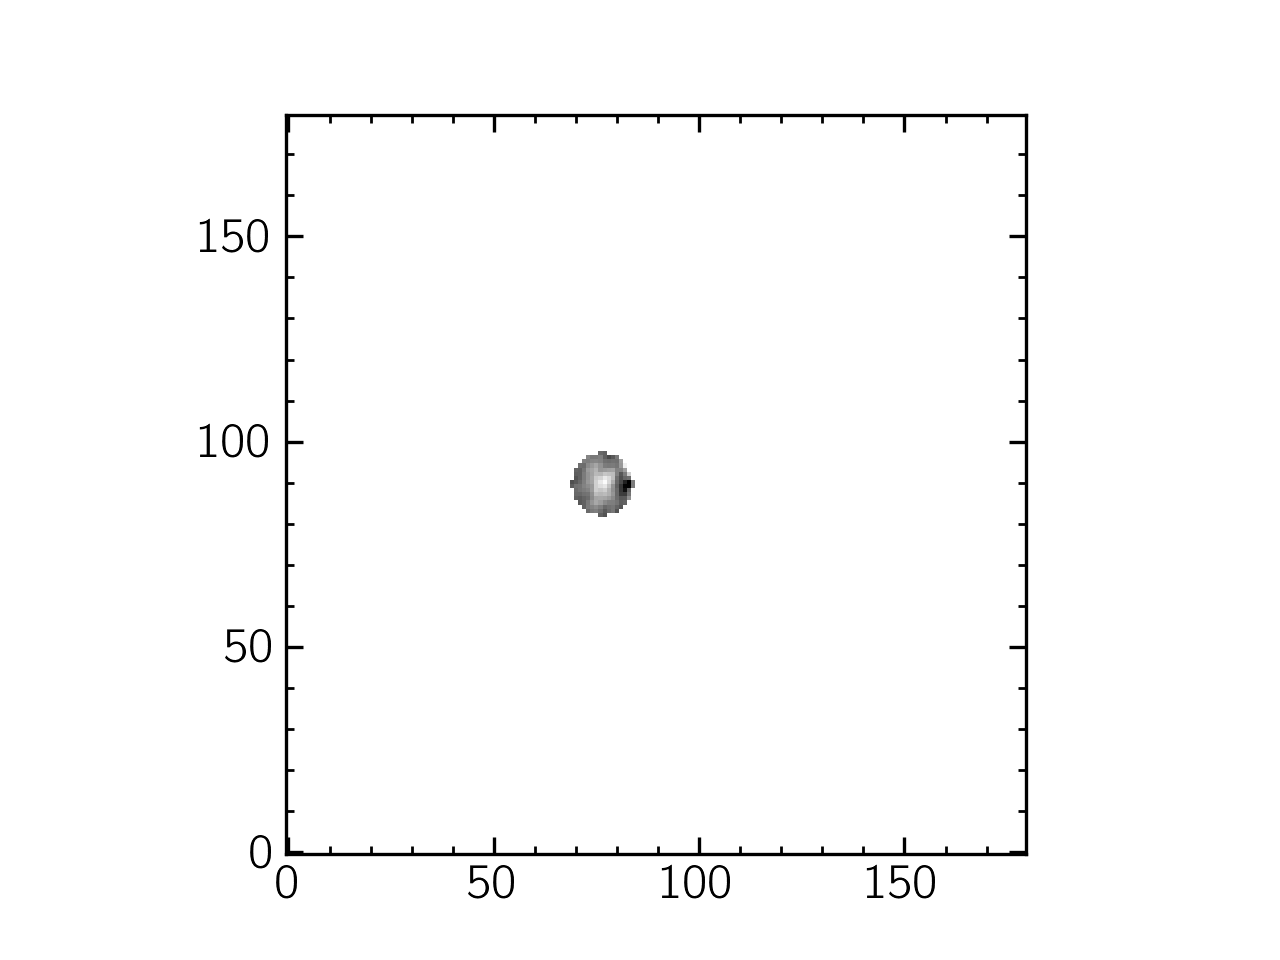

In [38]:
radius = lod_to_pixels(1., 3.77)
xx,yy = np.meshgrid(np.arange(SynthCubeObjectBDI2.A_Reduced.shape[1])-xs,
                    np.arange(SynthCubeObjectBDI2.A_Reduced.shape[1])-ys)
r=np.hypot(xx,yy)
grab_them = np.where(r<radius)
mask = np.empty(SynthCubeObjectBDI2.A_Reduced.shape)
mask[:] = np.nan
mask[grab_them] = 1

grabbed = SynthCubeObjectBDI2.A_Reduced*mask

rms = np.sqrt(np.nanmean(grabbed**2))
print(rms)
std = np.nanstd(grabbed)
print(std)

%matplotlib inline
im = SynthCubeObjectBDI2.A_Reduced*mask
#plt.imshow(im, norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.imshow(im)

# Put it together:

In [1]:
def injectplanet(image, imhdr, template, x, y, contrast, TC, xc, yc, 
                 pixscale = 15.9,
                 wavelength = 'none',
                 box = 70,
                 inject_negative_signal = False
                ):
    ''' Using a template psf, place a fake planet at the desired x,y and
        contrast from the central object.  PA is measured relative to true north
        (rather than up in image)
    '''
    from cliotools.bditools import makeplanet
    
    # compute sep in pixels

    newx, newy = (xc - x), (yc - y)
    sep = np.sqrt(newx**2 + newy**2)
    pa = (np.degrees(np.arctan2(newx,-newy)) ) % 360
    
    # pa input - rotate from angle relative to north to angle relative to image up:
    #    do the opposite of what you do to derotate images
    NORTH_CLIO = -1.80
    derot = (imhdr['ROTOFF'] - 180. + NORTH_CLIO) % 360
    
    pa = (pa + derot)
        
    # Get cartesian location of planet:
    xx = sep*np.sin(np.radians((pa)))
    yy = sep*np.cos(np.radians((pa)))
    xs = np.int_(np.floor(xc-xx))
    ys = np.int_(np.floor(yc+yy))
    # Make planet from template at desired contrast
    Planet = makeplanet(template, contrast, TC)
    # Make copy of image:
    synth = image.copy()
    # Get shape of template:
    boxy, boxx = np.int_(Planet.shape[0]/2),np.int_(Planet.shape[1]/2)
    x,y = xs,ys
    ymin, ymax = y-boxy, y+boxy
    xmin, xmax = x-boxx, x+boxx
    # Correct for sources near image edge:
    delta = 0
    if ymin < 0:
        delta = ymin
        ymin = 0
        Planet = Planet[(0-delta):,:]
    if ymax > image.shape[0]:
        delta = ymax - image.shape[0]
        ymax = image.shape[0]
        Planet = Planet[:(2*boxy-delta) , :]
    if xmin < 0:
        delta = xmin
        xmin = 0
        Planet = Planet[:,(0-delta):]
    if xmax > image.shape[1]:
        delta = xmax - image.shape[1]
        xmax = image.shape[1]
        Planet = Planet[:,:(2*boxx-delta)]
    if inject_negative_signal:
        Planet = Planet * (-1)
    # account for integer pixel positions:
    if synth[ymin:ymax,xmin:xmax].shape != Planet.shape:
        try:
            synth[ymin:ymax+1,xmin:xmax] = synth[ymin:ymax+1,xmin:xmax] + (Planet)
        except:
            synth[ymin:ymax,xmin:xmax+1] = synth[ymin:ymax,xmin:xmax+1] + (Planet)
    else:
        synth[ymin:ymax,xmin:xmax] = synth[ymin:ymax,xmin:xmax] + (Planet)
    return synth

def injectplanets(image, imhdr, template, x, y, contrast, TC, xc, yc, 
                  inject_negative_signal = True, **kwargs):
    ''' Wrapper for injectplanet() that allows for multiple fake planets in one image.
        Parameters are same as injectplanet() except sep, pa, and contrast must all be
        arrays of the same length.  **kwargs are passed to injectplanet().
    '''
    synth = image.copy()
    try:
        for i in range(len(sep)):
            synth1 = injectplanet(synth, imhdr, template, x[i], y[i], contrast[i], TC, xc, yc, 
                                      inject_negative_signal = inject_negative_signal,
                                      **kwargs)
            synth = synth1.copy()
    except:
        synth = injectplanet(synth, imhdr, template, x, y, contrast, TC, xc, yc, 
                                      inject_negative_signal = inject_negative_signal,
                                      **kwargs)
    return synth

class SyntheticSignal(object):
    def __init__(self, k, Star, x, y, C, boxsize = 50,
                sciencecube = [], refcube = [], 
                template = [], TC = None, use_same = True, verbose = True,
                inject_negative_signal = True, wavelength = 3.77
                ):
        ''' Class for creating and controling images with synthetic point source signals ("planet") injected.
        '''
        self.k = k
        self.Star = Star
        self.x = x
        self.y = y
        self.C = C
        self.verbose = verbose
        self.sciencecube = sciencecube
        self.refcube = refcube
        self.template = template
        box = sciencecube.shape[1] / 2
        
        synthcube = np.zeros(np.shape(self.sciencecube))
        # Inject planet signal into science target star:
        center = (0.5*((self.sciencecube.shape[2])-1),0.5*((self.sciencecube.shape[1])-1))
        # inject signal:
        for i in range(self.sciencecube.shape[0]):
            if TC == None:
                from cliotools.bditools import contrast
                # Get template constrast of refcube to sciencecube
                TC = contrast(self.sciencecube[i],self.templatecube[i],center,center)
            imhdr = fits.getheader(k['filename'].loc[i])
            synth = injectplanets(self.sciencecube[i], imhdr, self.template, x, y, C, TC, box, box,
                                  wavelength = wavelength, box = box, 
                                        inject_negative_signal = inject_negative_signal)
            synthcube[i,:,:] = synth
                
        self.synthcube = synthcube.copy()
        

In [3]:
from cliotools.bditools import contrast
path = "BDI1350/box90/"
sp = pickle.load(open('system-parameters.pkl','rb'))

Star = 'A'

# Open saved cleaned cubes:
astamp = fits.getdata('acube_box90_bpf-best.fits')
bstamp = fits.getdata('bcube_box90_bpf-best.fits')

K_klip = sp[path+'K_klipA']
box = astamp.shape[1] * 0.5
inner_mask = 0.5
from cliotools.bditools import lod_to_pixels
inner_mask = lod_to_pixels(inner_mask, 3.77)
outer_mask = box

k = pd.read_csv('CleanList.csv', comment='#')

xc,yc = 0.5*((2*box)-1), 0.5*((2*box)-1)
xs,ys = 76.5, 89.5
xmin, xmax = 65, xc
ymin = 78
ymax = ys + (ys-ymin)
ymin,ymax

xrange = np.arange(xmin,xmax,0.5)
yrange = np.arange(ymin,ymax,0.5)
contrastrange = np.arange(4.5,7.2,0.1)

template = np.median(bstamp, axis=0)
sciencecube = astamp
refcube = bstamp
center = (xc, yc)
TC = contrast(np.median(sciencecube, axis=0),template,center,center)



NameError: name 'center' is not defined

80.0 93.0 4.799999999999999


<IPython.core.display.Javascript object>


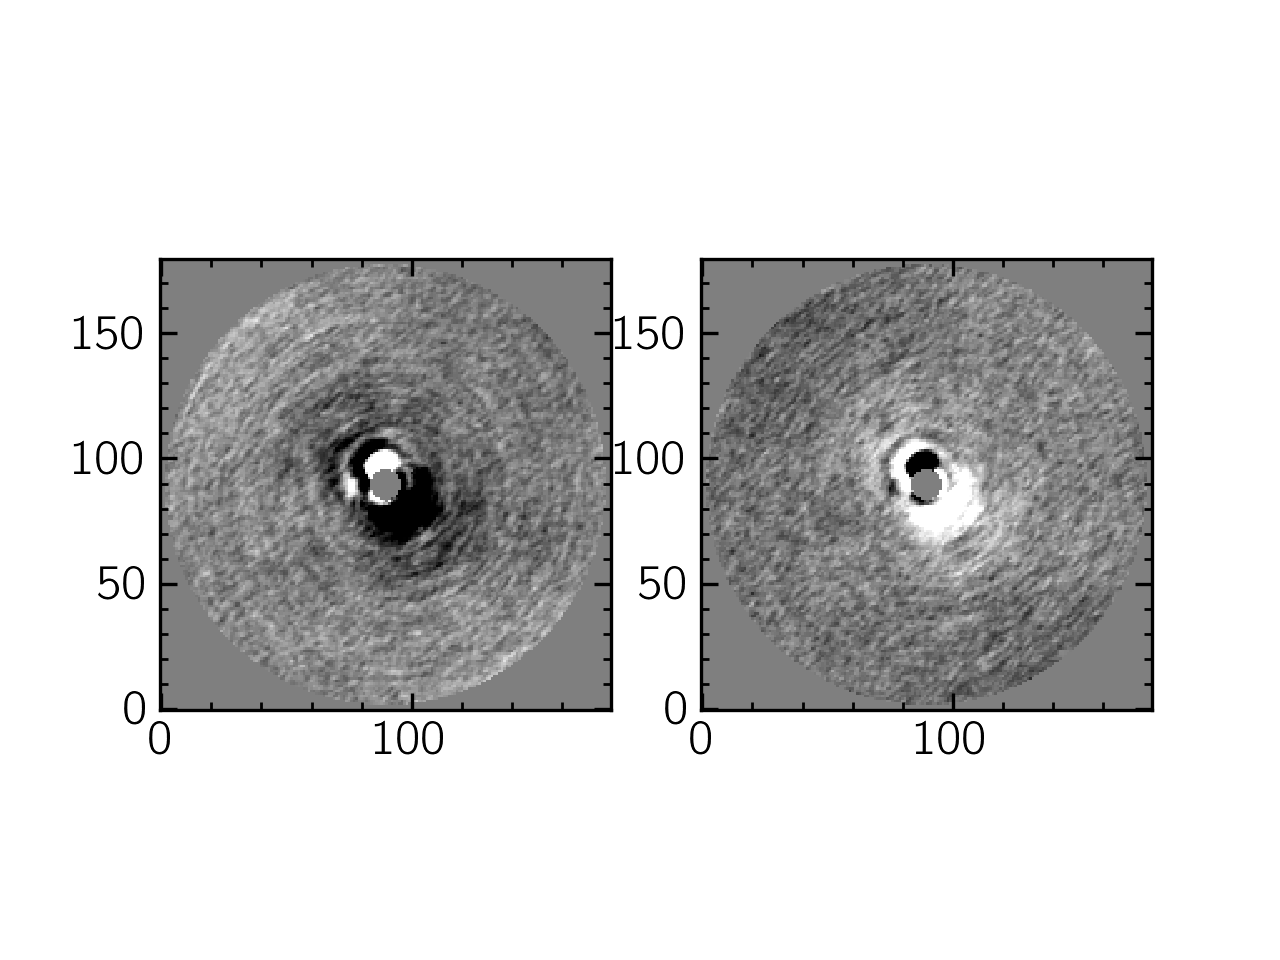

In [38]:
k = pd.read_csv('CleanList.csv', comment='#')
fullpath = ''

i = 30
j = 30
f = 3
print(xrange[i], yrange[j], contrastrange[f])

SynthCube = SyntheticSignal(k, Star, xrange[i], yrange[j], contrastrange[f],
                            sciencecube = sciencecube, refcube = refcube,
                            template = template, TC = TC, boxsize = box, inject_negative_signal = True)

from cliotools.bdi import BDI
SynthCubeObjectBDI2 = BDI(k, fullpath, K_klip = K_klip, 
                    boxsize = box, normalize = True, normalizebymask = False,       
                    inner_mask_core = True,        
                    inner_radius_format = 'pixels',
                    inner_mask_radius = inner_mask,        
                    outer_mask_annulus = True,     
                    outer_radius_format = 'pixels',
                    outer_mask_radius = outer_mask,       
                    mask_cval = 0,       
                    subtract_radial_profile = False,          
                    verbose = False,               
                    acube = SynthCube.synthcube,    
                    bcube = SynthCube.refcube   
                   )
# Do klip reduction:
SynthCubeObjectBDI2.Reduce(interp='bicubic',
             rot_cval=0.,
             mask_interp_overlapped_pixels = True
            ) 

radius = lod_to_pixels(1., 3.77)
xx,yy = np.meshgrid(np.arange(SynthCubeObjectBDI2.A_Reduced.shape[1])-xs,
                    np.arange(SynthCubeObjectBDI2.A_Reduced.shape[1])-ys)
r=np.hypot(xx,yy)
grab_them = np.where(r<radius)
mask = np.empty(SynthCubeObjectBDI2.A_Reduced.shape)
mask[:] = np.nan
mask[grab_them] = 1

grabbed = SynthCubeObjectBDI2.A_Reduced*mask

rms = np.sqrt(np.nanmean(grabbed**2))



%matplotlib inline
plt.subplot(121)
im = SynthCubeObjectBDI2.A_Reduced
plt.imshow(im, norm = ImageNormalize(im, interval=ZScaleInterval(),))
plt.subplot(122)
im = SynthCubeObjectBDI2.B_Reduced
plt.imshow(im, norm = ImageNormalize(im, interval=ZScaleInterval(),))

In [43]:
rmstable = pd.DataFrame(np.nan, index=range(len(xrange)*len(yrange)*len(contrastrange)), 
                                                columns = ['x','y','contrast','rms','std'])
rmstable

,x,y,contrast,rms,std
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
60853,NaN,NaN,NaN,NaN,NaN
60854,NaN,NaN,NaN,NaN,NaN
60855,NaN,NaN,NaN,NaN,NaN
60856,NaN,NaN,NaN,NaN,NaN


In [48]:
from myastrotools.tools import update_progress
count = 0
for i in range(len(xrange)):
    for j in range(len(yrange)):
        for f in range(len(contrastrange)):
            index = count
            data = {'x':xrange[i],'y':yrange[j],'contrast':contrastrange[f]}
            rmstable.loc[index] = data
            count += 1
            update_progress(count,len(rmstable))
            
            

100% (60858 of 60858): |####################|  Done...


In [50]:
rmstable.to_csv('rmstable.csv', index=False)

# Run loop

In [4]:
from cliotools.bditools import contrast

path = "BDI1350/box90/"
sp = pickle.load(open('system-parameters.pkl','rb'))

Star = 'A'

# Open saved cleaned cubes:
astamp = fits.getdata('acube_box90_bpf-best.fits')
bstamp = fits.getdata('bcube_box90_bpf-best.fits')

K_klip = sp[path+'K_klipA']
box = astamp.shape[1] * 0.5
inner_mask = 0.5

inner_mask = lod_to_pixels(inner_mask, 3.77)
outer_mask = box

k = pd.read_csv('CleanList.csv', comment='#')

xc,yc = 0.5*((2*box)-1), 0.5*((2*box)-1)
xs,ys = 76.5, 89.5
xmin, xmax = 65, xc
ymin = 78
ymax = ys + (ys-ymin)
ymin,ymax

xrange = np.arange(xmin,xmax,0.5)
yrange = np.arange(ymin,ymax,0.5)
contrastrange = np.arange(4.5,7.2,0.1)

template = np.median(bstamp, axis=0)
sciencecube = astamp
refcube = bstamp

center = (xc, yc)
TC = contrast(np.median(sciencecube, axis=0),template,center,center)

from cliotools.bditools import contrast
k = pd.read_csv('CleanList.csv', comment='#')
fullpath = path

rmstable = pd.read_csv('rmstable.csv')

In [5]:
import warnings
warnings.filterwarnings('ignore')

import time

for i in range(len(rmstable)):
    if i <= 10:
        start = time.time()
    SynthCube = SyntheticSignal(k, Star, rmstable['x'].loc[i], 
                                rmstable['y'].loc[i], rmstable['contrast'].loc[i],
                                sciencecube = sciencecube, refcube = refcube,
                                template = template, TC = TC, boxsize = box, inject_negative_signal = True)

    from cliotools.bdi import BDI
    SynthCubeObjectBDI2 = BDI(k, fullpath, K_klip = K_klip, 
                        boxsize = box, normalize = True, normalizebymask = False,       
                        inner_mask_core = True,        
                        inner_radius_format = 'pixels',
                        inner_mask_radius = inner_mask,        
                        outer_mask_annulus = True,     
                        outer_radius_format = 'pixels',
                        outer_mask_radius = outer_mask,       
                        mask_cval = 0,       
                        subtract_radial_profile = False,          
                        verbose = False,               
                        acube = SynthCube.synthcube,    
                        bcube = SynthCube.refcube   
                       )
    # Do klip reduction:
    SynthCubeObjectBDI2.Reduce(interp='bicubic',
                 rot_cval=0.,
                 mask_interp_overlapped_pixels = True
                ) 

    radius = lod_to_pixels(1., 3.77)
    xx,yy = np.meshgrid(np.arange(SynthCubeObjectBDI2.A_Reduced.shape[1])-xs,
                        np.arange(SynthCubeObjectBDI2.A_Reduced.shape[1])-ys)
    r=np.hypot(xx,yy)
    grab_them = np.where(r<radius)
    mask = np.empty(SynthCubeObjectBDI2.A_Reduced.shape)
    mask[:] = np.nan
    mask[grab_them] = 1

    grabbed = SynthCubeObjectBDI2.A_Reduced*mask

    rms = np.sqrt(np.nanmean(grabbed**2))
    std = np.nanstd(grabbed)
    
    rmstable['rms'].loc[i] = rms
    rmstable['std'].loc[i] = std
    
    if i <= 10:
        stop = time.time()
        print(stop - start)
        
    update_progress(i,len(rmstable))

1.402280330657959
0.0% (0 of 60858): |--------------------|  0.9137849807739258
0.0% (1 of 60858): |--------------------|  0.9276740550994873
0.0% (2 of 60858): |--------------------|  0.8979921340942383
0.0% (3 of 60858): |--------------------|  1.1685450077056885
0.0% (4 of 60858): |--------------------|  0.8965051174163818
0.0% (5 of 60858): |--------------------|  0.898535966873169
0.0% (6 of 60858): |--------------------|  0.9520981311798096
0.0% (7 of 60858): |--------------------|  0.8921310901641846
0.0% (8 of 60858): |--------------------|  0.8894760608673096
0.0% (9 of 60858): |--------------------|  0.9013481140136719
100.0% (60857 of 60858): |####################|  

In [6]:
rmstable.to_csv('rmstable.csv')

In [23]:
minind = np.where(rmstable['rms'] == np.min(rmstable['rms']))[0]
rmstable['x'].loc[minind],rmstable['y'].loc[minind],rmstable['contrast'].loc[minind]

(28010    76.0
 Name: x, dtype: float64,
 28010    90.5
 Name: y, dtype: float64,
 28010    5.6
 Name: contrast, dtype: float64)

<IPython.core.display.Javascript object>


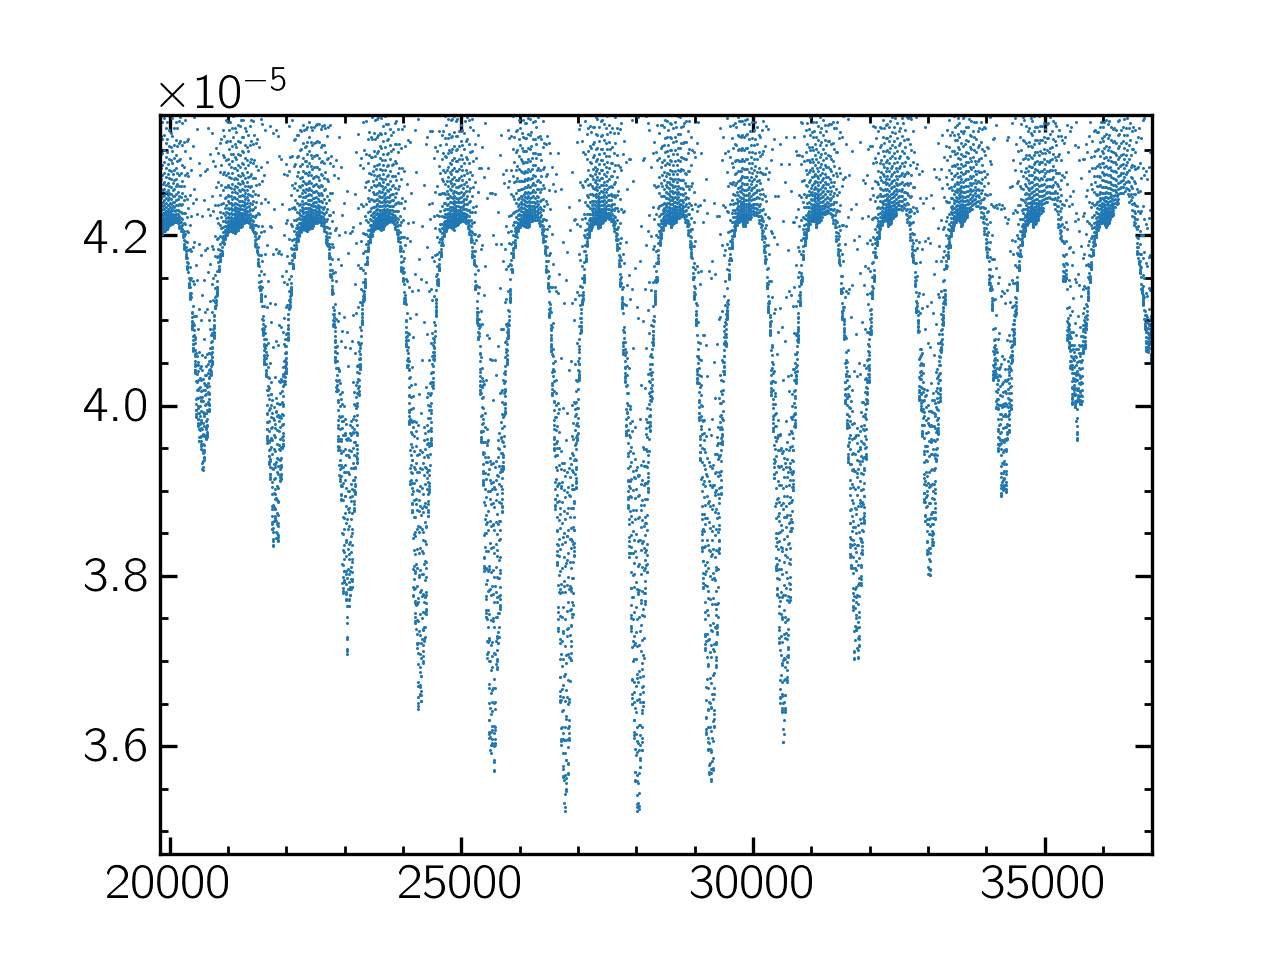

In [20]:
%matplotlib notebook
plt.plot(range(len(rmstable)),rmstable['rms'],ls='None',marker='.', markersize = 1)

In [35]:
contrastrange

array([4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7,
       5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. ,
       7.1])

#### Try narrowing the grid range:

In [62]:
xrange2 = np.arange(74.6,77,0.1)
yrange2 = np.arange(89.5,92.0,0.1)
contrastrange2 = np.arange(5.4,5.8,0.02)

rmstable2 = pd.DataFrame(np.nan, index=range(len(xrange2)*len(yrange2)*len(contrastrange2)), 
                                                columns = ['x','y','contrast','rms','std'])
len(rmstable2)

12500

In [63]:

count = 0
for i in range(len(xrange2)):
    for j in range(len(yrange2)):
        for f in range(len(contrastrange2)):
            index = count
            data = {'x':xrange2[i],'y':yrange2[j],'contrast':contrastrange2[f]}
            rmstable2.loc[index] = data
            count += 1
            update_progress(count,len(rmstable2))



100% (12500 of 12500): |####################|  Done...


In [64]:
import warnings
warnings.filterwarnings('ignore')

import time

for i in range(len(rmstable2)):
    SynthCube = SyntheticSignal(k, Star, rmstable2['x'].loc[i], 
                                rmstable2['y'].loc[i], rmstable2['contrast'].loc[i],
                                sciencecube = sciencecube, refcube = refcube,
                                template = template, TC = TC, boxsize = box, inject_negative_signal = True)

    from cliotools.bdi import BDI
    SynthCubeObjectBDI2 = BDI(k, fullpath, K_klip = K_klip, 
                        boxsize = box, normalize = True, normalizebymask = False,       
                        inner_mask_core = True,        
                        inner_radius_format = 'pixels',
                        inner_mask_radius = inner_mask,        
                        outer_mask_annulus = True,     
                        outer_radius_format = 'pixels',
                        outer_mask_radius = outer_mask,       
                        mask_cval = 0,       
                        subtract_radial_profile = False,          
                        verbose = False,               
                        acube = SynthCube.synthcube,    
                        bcube = SynthCube.refcube   
                       )
    # Do klip reduction:
    SynthCubeObjectBDI2.Reduce(interp='bicubic',
                 rot_cval=0.,
                 mask_interp_overlapped_pixels = True
                ) 

    radius = lod_to_pixels(1., 3.77)
    xx,yy = np.meshgrid(np.arange(SynthCubeObjectBDI2.A_Reduced.shape[1])-xs,
                        np.arange(SynthCubeObjectBDI2.A_Reduced.shape[1])-ys)
    r=np.hypot(xx,yy)
    grab_them = np.where(r<radius)
    mask = np.empty(SynthCubeObjectBDI2.A_Reduced.shape)
    mask[:] = np.nan
    mask[grab_them] = 1

    grabbed = SynthCubeObjectBDI2.A_Reduced*mask

    rms = np.sqrt(np.nanmean(grabbed**2))
    std = np.nanstd(grabbed)
    
    rmstable2['rms'].loc[i] = rms
    rmstable2['std'].loc[i] = std
        
    update_progress(i,len(rmstable2))

100.0% (12499 of 12500): |####################|  

In [66]:
rmstable2.to_csv('rmstable2.csv',index=False)

<IPython.core.display.Javascript object>


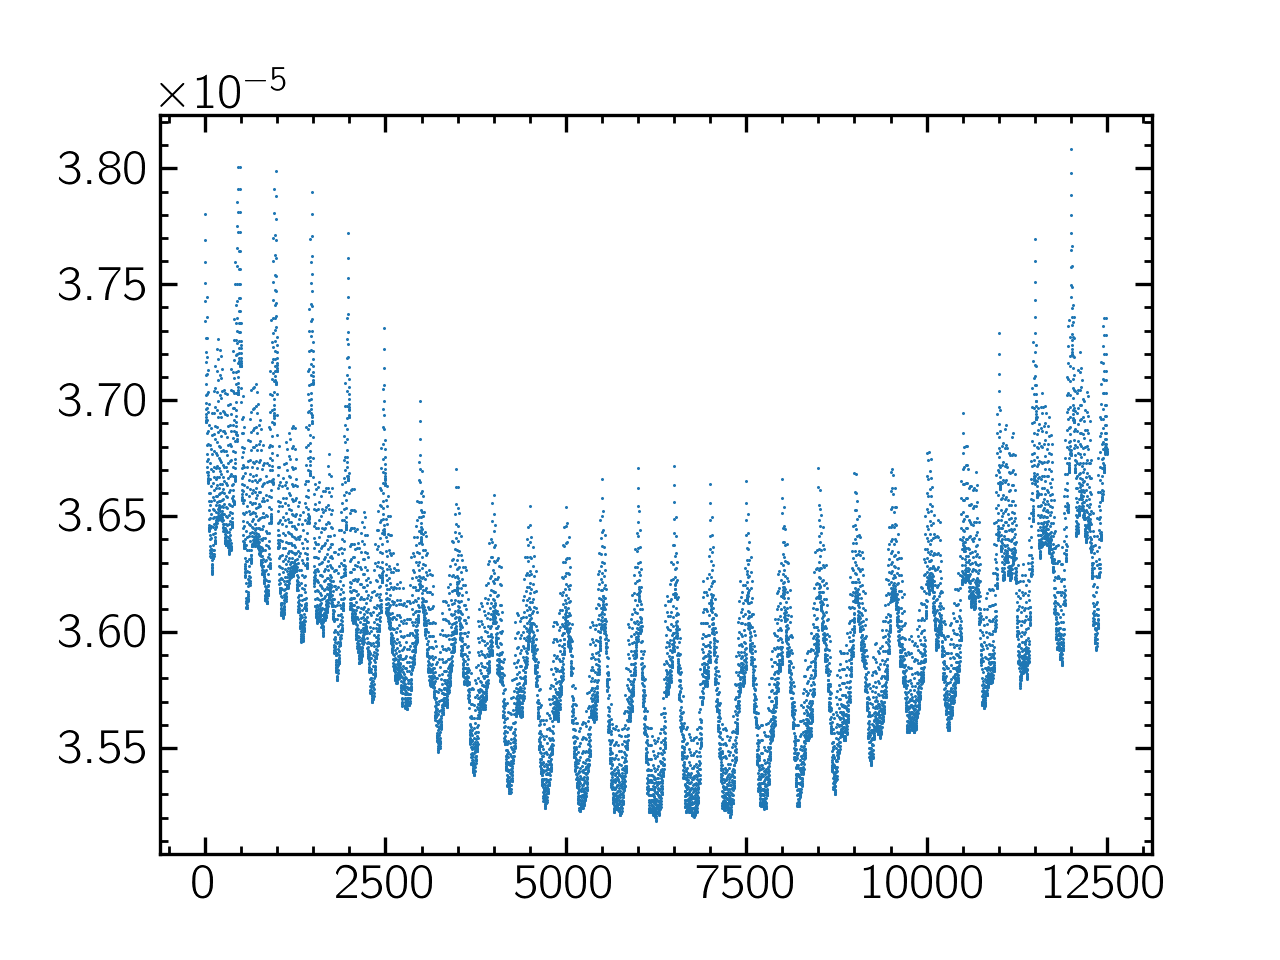

In [67]:
%matplotlib inline
plt.plot(range(len(rmstable2)),rmstable2['rms'],ls='None',marker='.', markersize = 1)

In [68]:
minind = np.where(rmstable2['rms'] == np.min(rmstable2['rms']))[0]
rmstable2['x'].loc[minind],rmstable2['y'].loc[minind],rmstable2['contrast'].loc[minind]

(6250    75.8
 Name: x, dtype: float64,
 6250    90.7
 Name: y, dtype: float64,
 6250    5.6
 Name: contrast, dtype: float64)

In [69]:
ind = np.where( (rmstable2['y'] == rmstable2['y'].loc[minind].item()) &
              (rmstable2['x'] == rmstable2['x'].loc[minind].item()))[0]
ind

array([6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249, 6250,
       6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 6259])

<IPython.core.display.Javascript object>


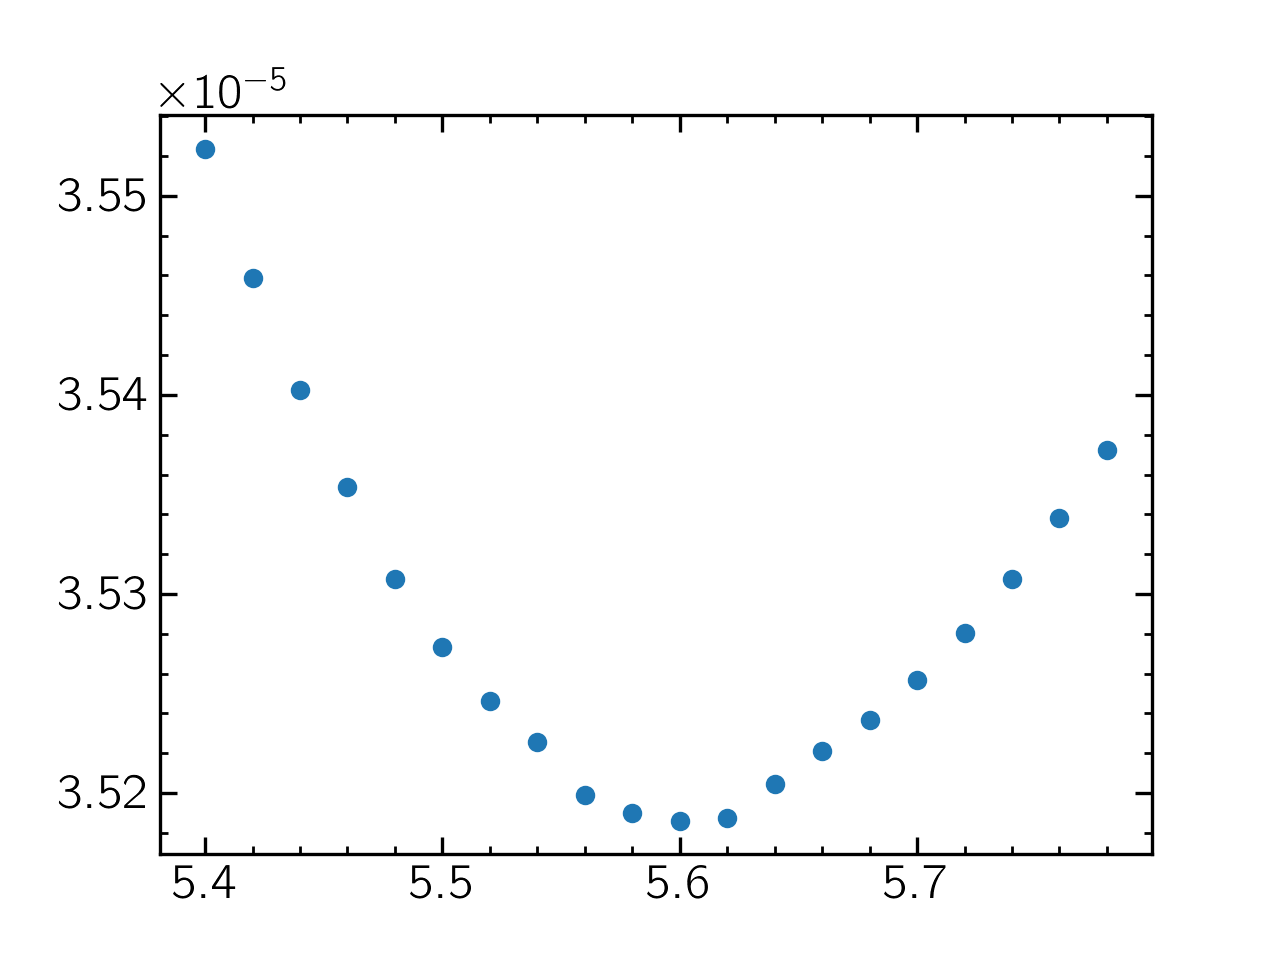

In [70]:
%matplotlib inline
plt.scatter(rmstable2['contrast'].loc[ind],rmstable2['rms'].loc[ind])